In [1]:
from astropy.io import fits
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import subprocess
from sklearn.cluster import DBSCAN
from analyzeImage import analyzeImage
import keras
from keras.models import load_model
from __future__ import print_function

Using TensorFlow backend.


In [2]:
gpu_code_path = "../code/gpu/"
real_image_name = "chip_7"
real_image_path = gpu_code_path+"images/"+real_image_name
psi_image_path = gpu_code_path+"output-images/psi"
phi_image_path = gpu_code_path+"output-images/phi"

In [3]:
def execute(cmd):
    popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True)
    for stdout_line in iter(popen.stdout.readline, ""):
        yield stdout_line 
    popen.stdout.close()
    return_code = popen.wait()
    if return_code:
        raise subprocess.CalledProcessError(return_code, cmd)

In [4]:
paramsFile = open('../code/gpu/debug/parameters.config', 'w')
paramsFile.write(
"""Debug ................ : 1
Image Count .......... : 5
Generate Images ...... : 0
Image Width .......... : 500
Image Height ......... : 500
PSF Sigma ............ : 1.0
Object Brightness .... : 360.0
Object Initial x ..... : 320.0
Object Initial y ..... : 180.0
Velocity x ........... : -1.3
Velocity y ........... : -0.2
Background Level ..... : 1024.0
Background Sigma ..... : 32.0
Mask Threshold ....... : 40.0
Mask Penalty ......... : -0.012
Angles to Search ..... : 50
Velocities to Search . : 30
Minimum Velocity ..... : 100
Maximum Velocity ..... : 500
Write to file ........ : 1
Source Images Path ... : ../../{source}/
Psi Images Path ...... : ../../{psi}/
Phi Images Path....... : ../../{phi}/
""".format( source=real_image_path, psi=psi_image_path, phi=phi_image_path ))
paramsFile.close()

In [5]:
popen = subprocess.Popen( "./clearImages.sh", stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE)
popen.wait()
output = popen.stderr.read()
output += popen.stdout.read()
print( output)

In [6]:
for path in execute("./search.sh"):
    print(path, end="")

Image Count ..........  : 5
Generate Images ......  : 0
Image Width ..........  : 500
Image Height .........  : 500
PSF Sigma ............  : 1.0
Object Brightness ....  : 360.0
Object Initial x .....  : 320.0
Object Initial y .....  : 180.0
Velocity x ...........  : -1.3
Velocity y ...........  : -0.2
Background Level .....  : 1024.0
Background Sigma .....  : 32.0
Mask Threshold .......  : 40.0
Mask Penalty .........  : -0.012
Angles to Search .....  : 50
Velocities to Search .  : 30
Minimum Velocity .....  : 100
Maximum Velocity .....  : 500
Write to file ........  : 1
Source Images Path ...  : ../../../code/gpu/images/chip_7/
Psi Images Path ......  : ../../../code/gpu/output-images/psi/
Phi Images Path.......  : ../../../code/gpu/output-images/phi/
Using Kernel Size 5X5
| 0.004 | 0.015 | 0.023 | 0.015 | 0.004 | 
 ---------------------------------------
| 0.015 | 0.058 | 0.093 | 0.058 | 0.015 | 
 ---------------------------------------
| 0.023 | 0.093 | 0.147 | 0.093 | 0.023 | 
 ---

In [7]:
raw_results = np.genfromtxt('../code/gpu/debug/results/results.txt', names=True)

In [8]:
image_mjd = []

for filename in sorted(os.listdir(real_image_path)):
    hdulist = fits.open(os.path.join(real_image_path, filename))
    image_mjd.append(hdulist[0].header['MJD'])

image_mjd = np.array(image_mjd)
image_times = image_mjd - image_mjd[0]
#image_times*=24.

Load Psi Images

In [9]:
hdulist = fits.open(os.path.join(psi_image_path, os.listdir(psi_image_path)[0]))
num_images = len(os.listdir(psi_image_path))
image_shape = np.shape(hdulist[0].data)
im_psi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(psi_image_path)))):

    #print (str('Loaded ' + filename))

    image_file = os.path.join(psi_image_path, filename)
    hdulist = fits.open(image_file)
    im_psi_array[idx] = hdulist[0].data#*mask


Load Phi Images (for potentially making psi/phi stamps)

In [10]:
hdulist = fits.open(os.path.join(phi_image_path, os.listdir(phi_image_path)[0]))
num_images = len(os.listdir(phi_image_path))
image_shape = np.shape(hdulist[0].data)
im_phi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(phi_image_path)))):

   # print (str('Loaded ' + filename))

    image_file = os.path.join(phi_image_path, filename)
    hdulist = fits.open(image_file)
    im_phi_array[idx] = hdulist[0].data#*mask


In [11]:
hdulist = fits.open(os.path.join(real_image_path, os.listdir(real_image_path)[0]))
num_images = len(os.listdir(real_image_path))
image_shape = np.shape(hdulist[1].data)
im_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(real_image_path)))):

   # print( str('Loaded ' + filename))

    image_file = os.path.join(real_image_path, filename)
    hdulist = fits.open(image_file)
    im_array[idx] = hdulist[1].data#*mask


In [12]:
ai = analyzeImage()

In [13]:
model = load_model('../data/kbmod_model.h5')

In [14]:
results = raw_results[0:2000]
results

array([(682.0, 1187.0, 0.0, 0.0, -6.279, -99.803, 6.907, 570.038),
       (682.0, 1188.0, 0.0, 0.0, -7.116, -113.11, 6.803, 561.728),
       (682.0, 1141.0, 0.0, 0.0, -6.279, 99.803, 6.647, 565.257), ...,
       (491.0, 2392.0, 0.0, 0.0, -142.566, 56.446, 4.335, 366.527),
       (340.0, 2936.0, 0.0, 0.0, -205.037, -25.902, 4.335, 374.952),
       (1826.0, 3675.0, 0.0, 0.0, -99.315, 54.599, 4.335, 355.73)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

In [15]:
filtered_results = ai.filter_results(im_array, results, image_times, model, chunk_size=2000)

Finished chunk 1 of 1


In [16]:
print( len(filtered_results) )
filtered_results

409


array([(1571.0, 599.0, 0.0, 0.0, 365.712, 144.796, 6.637, 562.086),
       (1570.0, 599.0, 0.0, 0.0, 378.109, 149.704, 6.241, 528.715),
       (1572.0, 600.0, 0.0, 0.0, 353.315, 139.887, 5.99, 508.151),
       (1572.0, 599.0, 0.0, 0.0, 353.315, 139.887, 5.959, 505.192),
       (329.0, 3041.0, 0.0, 0.0, -99.211, -12.533, 5.915, 508.123),
       (1571.0, 600.0, 0.0, 0.0, 365.712, 144.796, 5.859, 495.872),
       (328.0, 3041.0, 0.0, 0.0, -99.211, -12.533, 5.805, 502.168),
       (1570.0, 598.0, 0.0, 0.0, 378.109, 149.704, 5.775, 488.446),
       (1573.0, 600.0, 0.0, 0.0, 353.315, 139.887, 5.713, 483.859),
       (331.0, 3041.0, 0.0, 0.0, -112.44, -14.204, 5.706, 484.134),
       (328.0, 3040.0, 0.0, 0.0, -100.0, 0.0, 5.694, 492.742),
       (329.0, 3042.0, 0.0, 0.0, -96.858, -24.869, 5.636, 482.439),
       (329.0, 3040.0, 0.0, 0.0, -100.0, 0.0, 5.635, 483.927),
       (330.0, 3041.0, 0.0, 0.0, -112.44, -14.204, 5.619, 481.549),
       (1571.0, 598.0, 0.0, 0.0, 365.712, 144.796, 5.549, 4

In [17]:
results_to_cluster = filtered_results
arg = dict(eps=0.3, min_samples=1, n_jobs=-1)
clustered_results = ai.clusterResults(results_to_cluster, dbscan_args=arg)#, im_array, image_times)
clustered_results =  results_to_cluster[np.array(clustered_results[1], dtype=np.int)]
#best_targets = range(stamp_count)
#best_targets

In [18]:
print( len(clustered_results) )
clustered_results

4


array([(1571.0, 599.0, 0.0, 0.0, 365.712, 144.796, 6.637, 562.086),
       (329.0, 3041.0, 0.0, 0.0, -99.211, -12.533, 5.915, 508.123),
       (1369.0, 1931.0, 0.0, 0.0, 96.858, -24.869, 4.582, 374.806),
       (698.0, 3017.0, 0.0, 0.0, 303.727, 120.254, 4.501, 368.044)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

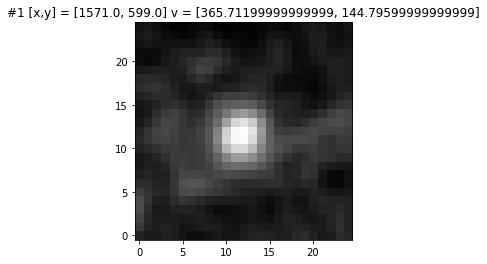

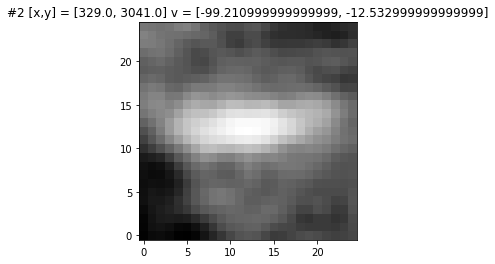

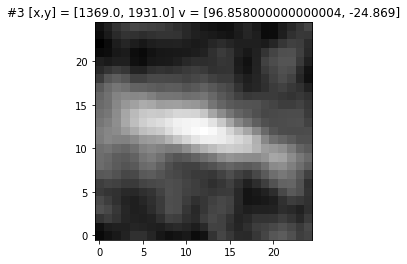

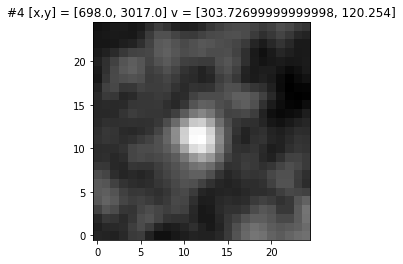

In [19]:
f_results = clustered_results
for imNum in range(min(len(f_results),50)):
    current = imNum#best_targets[imNum]    
    plt.imshow(ai.createPostageStamp(im_psi_array,
                                         list(f_results[['t0_x', 't0_y']][current]),
                                         np.array(list(f_results[['v_x', 'v_y']][current])),
                                         image_times, [25., 25.])[0],
                    origin='lower',
               cmap=plt.cm.Greys_r,
               interpolation='None')
    plt.title(str('#' + str(imNum+1) + ' [x,y] = ' + str(list(f_results[['t0_x', 't0_y']][current])))
                  + ' v = ' + str(list(f_results[['v_x', 'v_y']][current])))
 #   plt.savefig("stamps/stamp"+str(imNum+1)+".png")
    plt.show()
